In [217]:
import numpy as np

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

In [54]:
# plt.style.use('dark_background')

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams['savefig.dpi'] = 600
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedImage {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [289]:
def synthesize(length):
    def get_cartesian_coords(nums):
        theta = nums
        x = np.cos(theta)
        y = np.sin(theta)
        return [x,y]

    angle = np.random.uniform(-np.pi, np.pi)
    coordinates = get_cartesian_coords(angle)
    amplitudes = [abs(coord) for coord in coordinates]
    random_walk = [amplitudes]
    for _ in range(length-1):
        #generate random small change in angle
        direction = 0.01 * np.random.uniform(-1, 1)
        angle += direction
        coordinates = get_cartesian_coords(angle)
        amplitudes = [abs(coord) for coord in coordinates]
        random_walk.append(amplitudes)
    timestep = list(range(length))
    
    def generate(i):
        a = (((random_walk[i][0])*-1)*np.sin((0.0002)*i)) + ((random_walk[i][1])*np.sin(0.0002*i))
        b = 100
        c = np.random.normal(2, 0.10) #0.01
        x = np.round(a + b + c, decimals=2)
        return x
    
    X = np.array(list(map(generate, timestep)))[:, None]
    return X

In [290]:
data_train = synthesize(20000)

In [530]:
full_data_train = data_train.copy()

In [531]:
data_train = full_data_train[0:10000]
data_train.shape

(10000, 1)

In [291]:
data_val = synthesize(10000)

In [292]:
data_test = synthesize(10000)

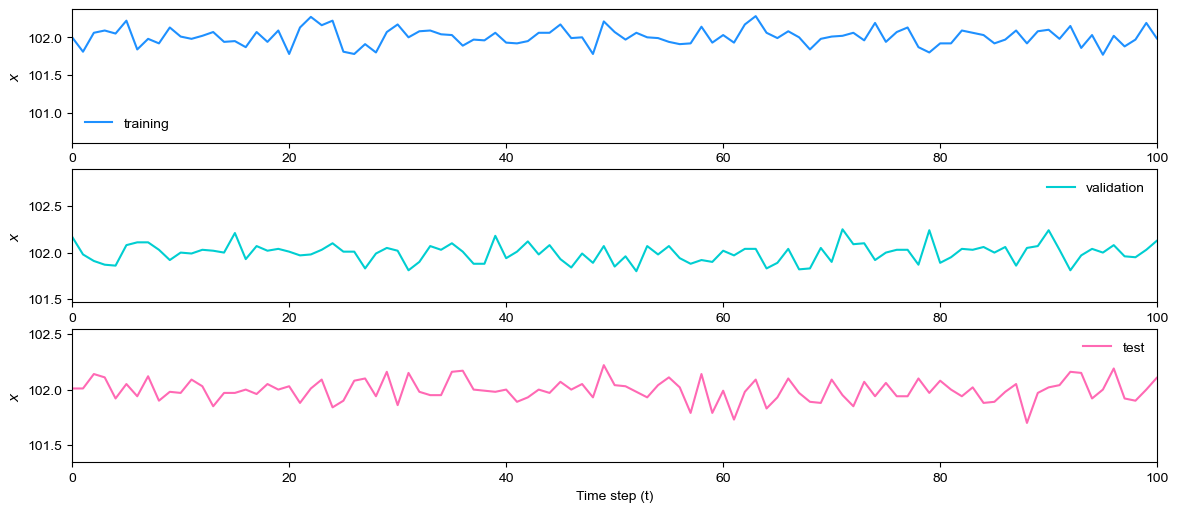

In [1091]:
data_fig, axs = plt.subplots(3, 1, figsize=(14, 6))
axs[0].plot(data_train, color='dodgerblue', label='training')
axs[1].plot(data_val, color='darkturquoise', label='validation')
axs[2].plot(data_test, color='hotpink', label='test')
axs[2].set_xlabel('Time step (t)')
for ax, data in zip(axs, (data_train, data_val, data_test)):
    ax.set_ylabel('$x$')
    ax.legend(frameon=False)
    ax.set_xlim(0, 100)
#     ax.set_ylim(98.5, 101)
plt.show()
data_fig.savefig('reports/synthetic-dataset-zoom.pdf', bbox_inches='tight')

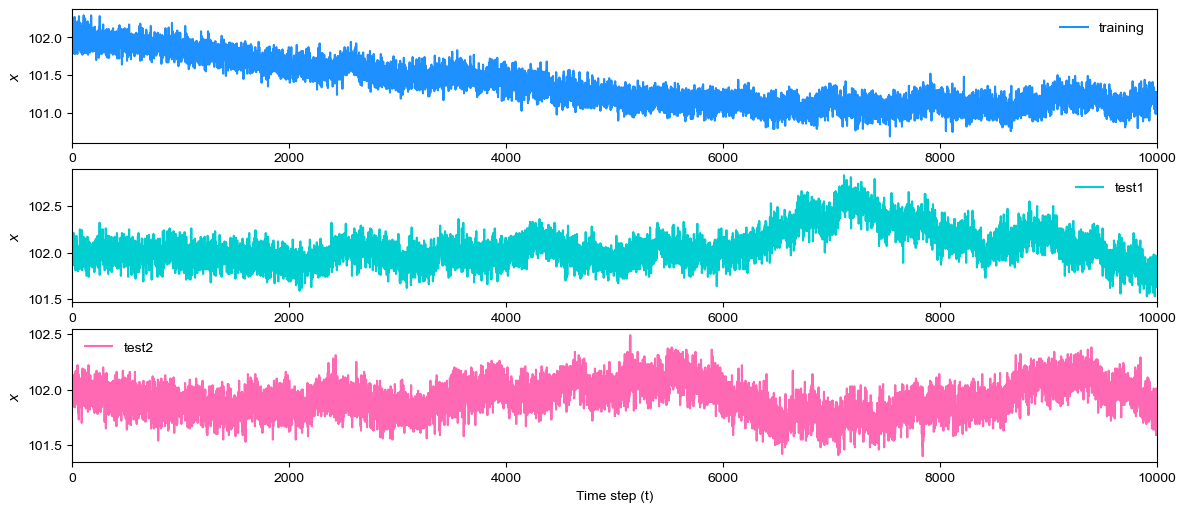

In [1093]:
data_fig, axs = plt.subplots(3, 1, figsize=(14, 6))
axs[0].plot(data_train, color='dodgerblue', label='training')
axs[1].plot(data_val, color='darkturquoise', label='test1')
axs[2].plot(data_test, color='hotpink', label='test2')
axs[2].set_xlabel('Time step (t)')
for ax, data in zip(axs, (data_train, data_val, data_test)):
    ax.set_ylabel('$x$')
    ax.legend(frameon=False)
    ax.set_xlim(0, len(data))
#     ax.set_ylim(98.5, 101)
plt.show()
data_fig.savefig('reports/synthetic-dataset.pdf', bbox_inches='tight')

In [297]:
def normalize(X):
    return (X - 99) / (110 - 99)

In [888]:
print('train', data_train.min(), data_train.max())
print('validation', data_val.min(), data_val.max())
print('test', data_test.min(), data_test.max())

train 100.69 102.29
validation 101.53 102.83
test 101.4 102.49


In [889]:
# data_train = normalize(data_train)
# data_val = normalize(data_val)
# data_test = normalize(data_test)

In [890]:
# sc = MinMaxScaler()
sc = StandardScaler()
norm_data_train = sc.fit_transform(data_train)
norm_data_val = sc.transform(data_val)
norm_data_test = sc.transform(data_test)

In [891]:
print('train', norm_data_train.min(), norm_data_train.max())
print('validation', norm_data_val.min(), norm_data_val.max())
print('test', norm_data_test.min(), norm_data_test.max())

train -2.211299402942736 3.0099787407976852
validation 0.5298716225209819 4.772160114310042
test 0.10564277334208975 3.6626385087651974


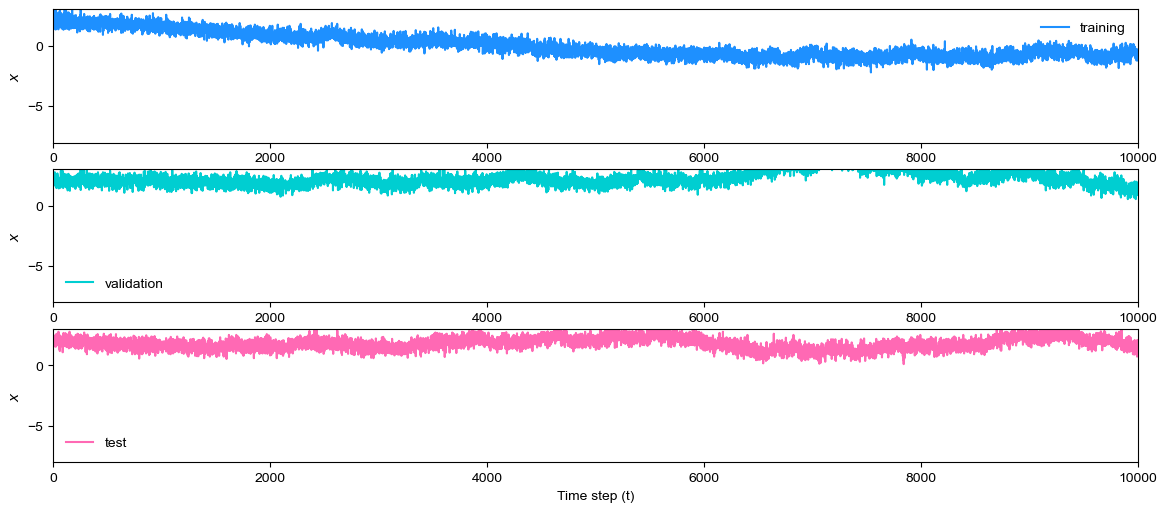

In [892]:
data_norm_fig, axs = plt.subplots(3, 1, figsize=(14, 6))
axs[0].plot(norm_data_train, color='dodgerblue', label='training')
axs[1].plot(norm_data_val, color='darkturquoise', label='validation')
axs[2].plot(norm_data_test, color='hotpink', label='test')
axs[2].set_xlabel('Time step (t)')
for ax, data in zip(axs, (norm_data_train, norm_data_val, norm_data_test)):
    ax.set_ylabel('$x$')
    ax.legend(frameon=False)
    ax.set_xlim(0, len(data))
    ax.set_ylim(-8, 3)
plt.show()
data_norm_fig.savefig('reports/synthetic-dataset-normalized.pdf', bbox_inches='tight')

In [934]:
def prepare_sequence(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

seq_length = 1000

# training
x, y = prepare_sequence(norm_data_train, seq_length)
train_size = int(len(y))
X_train = torch.Tensor(np.array(x)).float()
Y_train = torch.Tensor(np.array(y)).float()

# validation
x_val, y_val = prepare_sequence(norm_data_val, seq_length)
val_size = int(len(y_val))
X_val = torch.Tensor(np.array(x_val)).float()
Y_val = torch.Tensor(np.array(y_val)).float()

# test
x_test, y_test = prepare_sequence(norm_data_test, seq_length)
test_size = int(len(y_test))
X_test = torch.Tensor(np.array(x_test)).float()
Y_test = torch.Tensor(np.array(y_test)).float()

In [935]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, nonlinearity='tanh'):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,   # (batch, time_step, input_size)
            nonlinearity=nonlinearity,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x (batch, time_step, input_size)
        # hidden state = (n_layers, batch, hidden_size)
        # output = (batch, time_step, hidden_size)
        
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        output, h_n = self.rnn(x, h_0)
        h_n = h_n.view(-1, self.hidden_size)
        out = self.fc(h_n)
        
        return out

In [936]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,   # (batch, time_step, input_size)
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x (batch, time_step, input_size)
        # hidden state = (n_layers, batch, hidden_size)
        # output = (batch, time_step, hidden_size)
        
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [1079]:
hidden_size = 15
architecture = 'RNN' # 'LSTM'
nonlinearity = 'tanh'
is_clipped = False

In [1080]:
del model
if architecture == 'RNN':
    model = RNN(input_size=1, hidden_size=hidden_size, output_size=1, nonlinearity=nonlinearity).to(device) # 12
elif architecture == 'LSTM':
    model = LSTM(input_size=1, hidden_size=hidden_size, output_size=1).to(device) # 20
else:
    raise Error('invalid architecture')

In [1081]:
clip_value = 2

if is_clipped:
    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

In [1082]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [1083]:
count_parameters(model)

286

In [1084]:
def get_grads(model):
    grads = []
    for param in model.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    return grads

In [1085]:
train_dataset = TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True) # num_workers=8
train_loader_no_shuffle = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)

val_dataset = TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

In [1086]:
learning_rate = 1e-2
num_epochs = 5

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
gradients = {'min': [], 'max': [], 'mean': [], 'abs': []}
for epoch in (pbar := tqdm(range(num_epochs))):
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        outputs = model(X_batch)
        optimizer.zero_grad()
        error = criterion(outputs, Y_batch)
        error.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        train_loss += error.item()
        
        gradient = get_grads(model)
        min_grad = torch.abs(torch.min(gradient))
        max_grad = torch.abs(torch.max(gradient))
        mean_grad = torch.mean(torch.abs(gradient))
        abs_grad = torch.max(torch.abs(gradient))
        gradients['min'].append(min_grad.item())
        gradients['max'].append(max_grad.item())
        gradients['mean'].append(mean_grad.item())
        gradients['abs'].append(abs_grad.item())
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    for X_batch, Y_batch in val_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        outputs = model(X_batch)
        val_loss += criterion(outputs, Y_batch).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    pbar.set_description(f'Epoch: {epoch}, train loss: {train_loss:.5f}, val_loss: {val_loss:.5f}')

Epoch: 4, train loss: 0.12770, val_loss: 0.96124: 100%|██████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


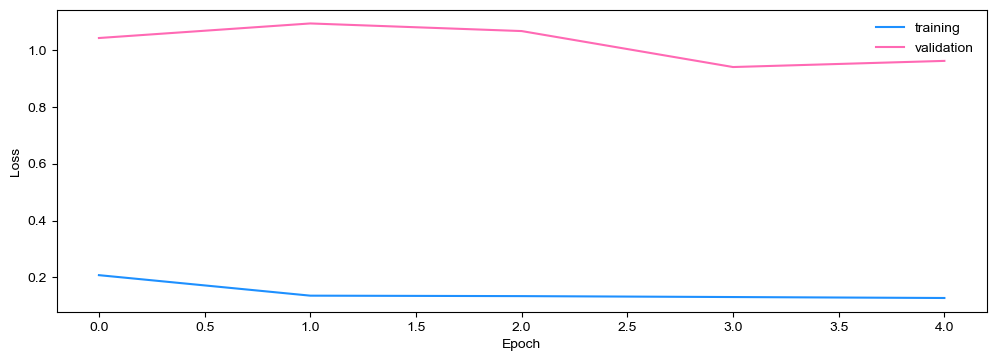

In [1087]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(train_losses, color='dodgerblue', label='training')
ax.plot(val_losses, color='hotpink', label='validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

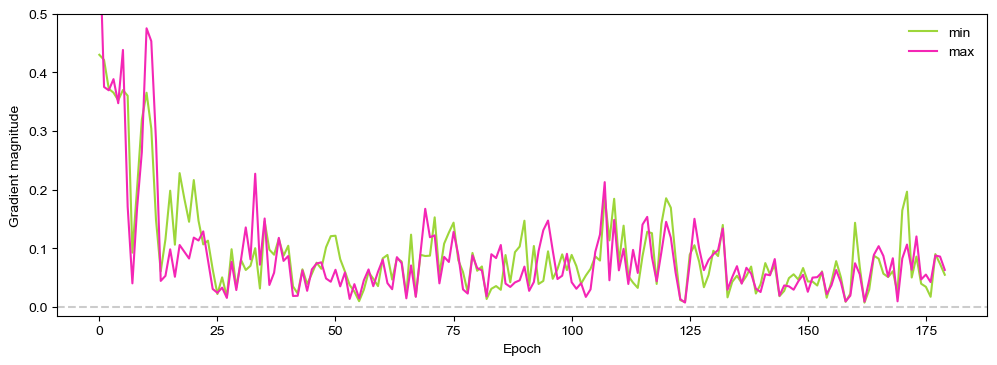

In [1088]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(gradients['min'], color='#9dd63a', label='min')
ax.plot(gradients['max'], color='#f426b5', label='max')
# ax.plot(gradients['mean'], color='dodgerblue', label='max(mean)')
# ax.plot(gradients['abs'], color='darkorange', label='max(abs)')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

ax.set_ylim(-0.015, 0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Gradient magnitude')
ax.legend(frameon=False)
fig.savefig('reports/synthetic-rnn-tanh-gradient-no_clip.pdf', bbox_inches='tight')

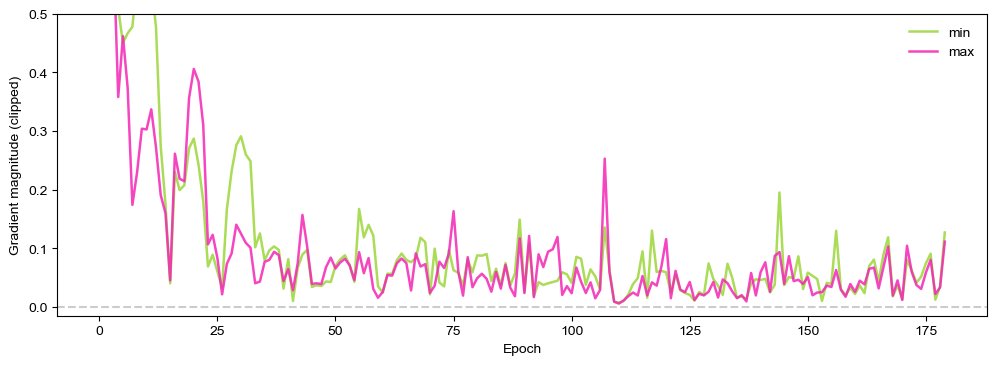

In [1054]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(gradients['min'], color='#9dd63a', alpha=0.85, lw=1.8, label='min')
ax.plot(gradients['max'], color='#f426b5', alpha=0.85, lw=1.8, label='max')
# ax.plot(gradients['mean'], color='dodgerblue', label='max(mean)')
# ax.plot(gradients['abs'], color='darkorange', label='max(abs)')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.4)

ax.set_ylim(-0.015, 0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Gradient magnitude (clipped)')
ax.legend(frameon=False)
fig.savefig('reports/synthetic-rnn-tanh-gradient-clip.pdf', bbox_inches='tight')

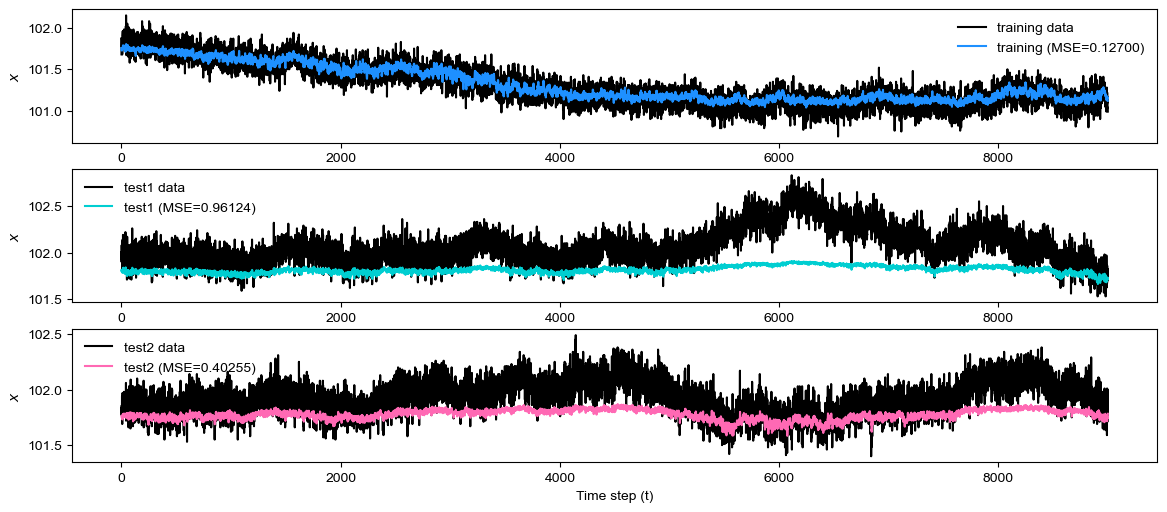

In [1089]:
model.eval()
losses = [0] * 3
train_predict, val_predict, test_predict = [], [], []
for i, (loader, prediction) in enumerate(zip((train_loader_no_shuffle, val_loader, test_loader), (train_predict, val_predict, test_predict))):
    for X_batch, Y_batch in loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        outputs = model(X_batch)
        losses[i] += criterion(outputs, Y_batch).item()
        prediction.extend(outputs.detach().cpu().numpy())
    losses[i] /= len(loader)

train_predict = sc.inverse_transform(np.array(train_predict))
val_predict = sc.inverse_transform(np.array(val_predict))
test_predict = sc.inverse_transform(np.array(test_predict))
    
Y_train_values = sc.inverse_transform(Y_train.detach().cpu().numpy())
Y_val_values = sc.inverse_transform(Y_val.detach().cpu().numpy())
Y_test_values = sc.inverse_transform(Y_test.detach().cpu().numpy())

datasets_prediction_fig, axs = plt.subplots(3, 1, figsize=(14, 6))

axs[0].plot(Y_train_values, color='black', label='training data')
axs[0].plot(train_predict, color='dodgerblue', label=f'training (MSE={losses[0]:.5f})')
axs[1].plot(Y_val_values, color='black', label='test1 data')
axs[1].plot(val_predict, color='darkturquoise', label=f'test1 (MSE={losses[1]:.5f})')
axs[2].plot(Y_test_values, color='black', label='test2 data')
axs[2].plot(test_predict, color='hotpink', label=f'test2 (MSE={losses[2]:.5f})')

axs[2].set_xlabel('Time step (t)')
for ax in axs:
    ax.set_ylabel('$x$')
    ax.legend(frameon=False)
#     ax.set_ylim(99, 101)
plt.show()
datasets_prediction_fig.savefig('reports/synthetic-predictions-tanh-no_clip.pdf', bbox_inches='tight')

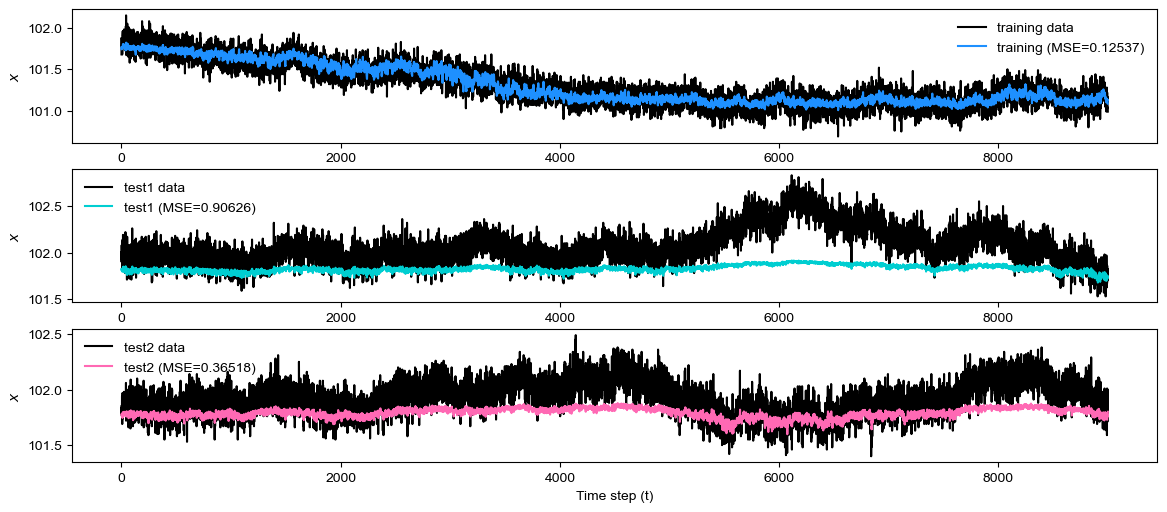

In [1055]:
model.eval()
losses = [0] * 3
train_predict, val_predict, test_predict = [], [], []
for i, (loader, prediction) in enumerate(zip((train_loader_no_shuffle, val_loader, test_loader), (train_predict, val_predict, test_predict))):
    for X_batch, Y_batch in loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        outputs = model(X_batch)
        losses[i] += criterion(outputs, Y_batch).item()
        prediction.extend(outputs.detach().cpu().numpy())
    losses[i] /= len(loader)

train_predict = sc.inverse_transform(np.array(train_predict))
val_predict = sc.inverse_transform(np.array(val_predict))
test_predict = sc.inverse_transform(np.array(test_predict))
    
Y_train_values = sc.inverse_transform(Y_train.detach().cpu().numpy())
Y_val_values = sc.inverse_transform(Y_val.detach().cpu().numpy())
Y_test_values = sc.inverse_transform(Y_test.detach().cpu().numpy())

datasets_prediction_fig, axs = plt.subplots(3, 1, figsize=(14, 6))

axs[0].plot(Y_train_values, color='black', label='training data')
axs[0].plot(train_predict, color='dodgerblue', label=f'training (MSE={losses[0]:.5f})')
axs[1].plot(Y_val_values, color='black', label='test1 data')
axs[1].plot(val_predict, color='darkturquoise', label=f'test1 (MSE={losses[1]:.5f})')
axs[2].plot(Y_test_values, color='black', label='test2 data')
axs[2].plot(test_predict, color='hotpink', label=f'test2 (MSE={losses[2]:.5f})')

axs[2].set_xlabel('Time step (t)')
for ax in axs:
    ax.set_ylabel('$x$')
    ax.legend(frameon=False)
#     ax.set_ylim(99, 101)
plt.show()
datasets_prediction_fig.savefig('reports/synthetic-predictions-gradient_clipping.pdf', bbox_inches='tight')

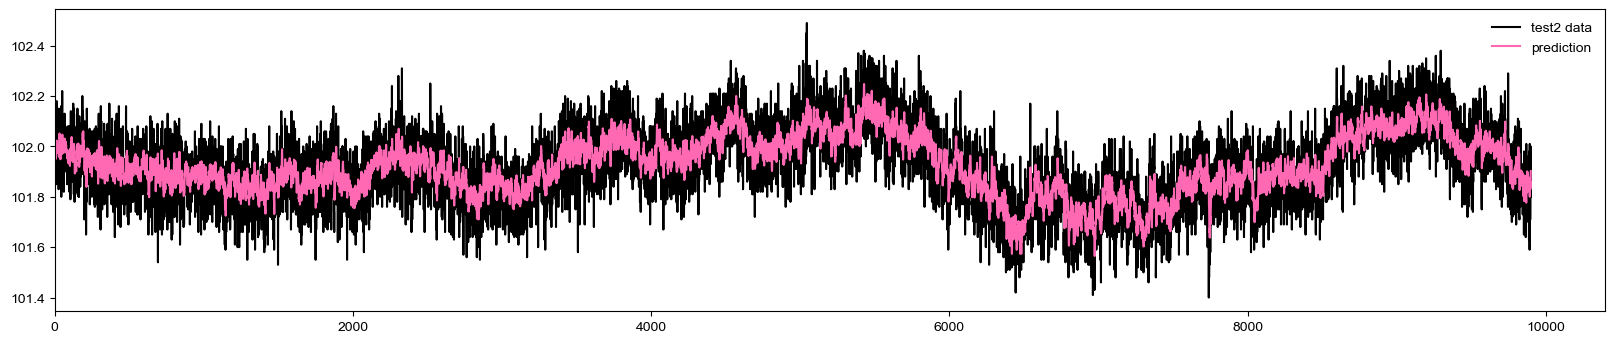

In [933]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(Y_test_values, color='black', label='test2 data')
ax.plot(test_predict, color='hotpink', label='prediction')
# ax.set_xticks(xticks)
ax.set_xlim(0)
ax.set_title('')
ax.legend(frameon=False)
fig.savefig('reports/synthetic-prediction-test.pdf', bbox_inches='tight')
plt.show()